In [14]:
import os, json, sys, gzip, pickle
sys.path.append('../src')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde
from utils import TargetGroupElements, FunctionalGroupElements

data_root = '/home/jhyang/WORKSPACES/DATA/synthesis/SynthesisSimilarity/rsc'
os.listdir(data_root)

['ele_order_counter.json',
 'pre_count_normalized_by_rxn_ss.json',
 'data_split.npz',
 'reactions_v20_20210820_ss.jsonl']

# Raw file parsing

- raw data file

In [13]:
# raw json file
with open(f'{data_root}/reactions_v20_20210820_ss.jsonl') as f:
    full_data = [json.loads(l) for l in list(f)]

i = np.random.randint(len(full_data))

_data = full_data[36728]

#for _data in full_data:
#    if _data['doi'] != '10.1103/physrevb.95.054430':
#        continue

def print_data(dat):
    for key in ['material_string','material_formula']:
        print(key, '\t:', dat[key])
    for _d in dat['composition']:
        print('\t', _d['formula'], '/', _d['elements'])
print(i, _data['doi'])
print_data(_data['target'])
print()
for _prec in _data['precursors']: print_data(_prec)



- raw numpy file

In [15]:
# raw numpy file
npz_data = {k:v for k,v in np.load(f'{data_root}/data_split.npz', allow_pickle=True).items()}

- check data

In [16]:
# check 
for ds_rxn, ds in npz_data.items():
    for i, data in enumerate(ds):
#        n = (d['target_comp'][0] != d['target_comp_featurized'][0]).sum()
        chem = data['prototype_path'][0].split('/')[-1]
        if data['doi'] == '10.1016/j.actamat.2006.08.010':
            print(ds_rxn, i)
            for prot in data['prototype_path']:
                print(prot.split('/')[4:])

train_reactions 8866
['Mg0.3Nb0.7PbO3', 'NoDoping', 'Mg0.333Nb0.66699994Pb1O3', 'Mg0.333Nb0.66699994Pb1O3']


In [19]:
import re

re_spec = re.compile(r'\d+(\.\d+)?')
re_ele = re.compile(r'[A-Z][a-z]?')
print(chem)
chem = data['prototype_path'][0].split('/')[-1]
ns = [float(m.group()) for m in re_spec.finditer(chem)]
eles = [m.group() for m in re_ele.finditer(chem)]
print(eles, ns)
#comp = dat['target_comp'][0]
#m = comp != 0
#
#for i in np.where(m)[0]:
#    print(i, comp[i])

Y0.00200057Al0.05487283Si0.37153473N0.51443273O0.05715919
['Y', 'Al', 'Si', 'N', 'O'] [0.00200057, 0.05487283, 0.37153473, 0.51443273, 0.05715919]


In [17]:
for ds_rxn, ds in npz_data.items():
    for i, data in enumerate(ds):
        if len(data['target_comp']) != 1:
            print(ds_rxn, i, data['raw_id'])

# Parsing data

- Changing composition vector to composition dictionary
- Unfiying temperature and time scales

In [20]:
ele_dict = {i:{} for i in range(100)}
#for d in npz_data['test_reactions']:
units = {'temp':{}, 'time':{}}
for ds_rxn, dataset in npz_data.items():
    for i, data in enumerate(dataset):
        chem = data['prototype_path'][0].split('/')[-1]
        if '(' in chem: continue
        ns = [float(m.group()) for m in re_spec.finditer(chem)]
        eles = [m.group() for m in re_ele.finditer(chem)]
        if len(eles) != len(ns): continue
        comp = data['target_comp'][0]
        idxs = np.where(comp != 0)[0]
#        print(chem)
#        print(eles)
#        print(ns)
#        print(comp[idxs] * np.sum(ns))
    #    print(idxs)
        for n, ele in zip(ns, eles):
            j = np.where(np.abs(comp[idxs] * np.sum(ns) - n) < 1e-3)[0]
            if len(j) != 1:
                continue
            k = idxs[j[0]]
#            print(ele, j[0], idxs[j[0]])
            if ele not in ele_dict[k].keys():
                ele_dict[k][ele] = 0
            ele_dict[k][ele] += 1
#            if ele_dict[k][ele] < 15:
#                ele_dict[k]['ids'].append(data['doi'])
        for op in data['operations']:
            for temp in op['attributes']['temperature']:
                unit = temp['units']
                if unit not in units['temp'].keys():
                    units['temp'][unit] = 0
                units['temp'][unit] +=1
            for time in op['attributes']['time']:
                unit = time['units']
                if unit not in units['time'].keys():
                    units['time'][unit] = 0
                units['time'][unit] +=1
                

In [22]:
ele_mapper = {}
ele_indexer = [v for k,v in ele_dict.items()]
for k, v in ele_dict.items():
    if len(v.keys()) == 1:
        ele = list(v.keys())[0]
        ele_mapper[ele] = k
        ele_indexer[k] = ele

print(json.dumps(ele_dict, indent=4))
print(json.dumps(ele_mapper, indent=4))
#with open('../dump/ele_mapper.json','w') as f:
#    json.dump(ele_mapper, f, indent=4)

{
    "0": {
        "Cs": 87
    },
    "1": {
        "K": 70
    },
    "2": {
        "Rb": 24
    },
    "3": {
        "Ba": 4731
    },
    "4": {
        "Na": 1774
    },
    "5": {
        "Sr": 4884
    },
    "6": {
        "Li": 2728
    },
    "7": {
        "Ca": 4139
    },
    "8": {
        "La": 4719
    },
    "9": {
        "Tb": 466
    },
    "10": {
        "Yb": 475
    },
    "11": {
        "Ce": 1632
    },
    "12": {
        "Pr": 629
    },
    "13": {
        "Nd": 822
    },
    "14": {
        "Sm": 747
    },
    "15": {
        "Eu": 1396
    },
    "16": {
        "Gd": 1048
    },
    "17": {
        "Dy": 402
    },
    "18": {
        "Y": 2272
    },
    "19": {
        "Ho": 214
    },
    "20": {
        "Er": 267
    },
    "21": {
        "Tm": 56
    },
    "22": {
        "Lu": 330
    },
    "23": {
        "Pu": 17
    },
    "24": {
        "Am": 2
    },
    "25": {
        "Cm": 1
    },
    "26": {
        "Hf": 158
    },
    "27": 

In [24]:
#units
unit_convertors = {
    '°C': lambda x: x + 273.15,
    'C': lambda x: x + 273.15,
    'K': lambda x: x,
    'h': lambda x: x,
    'hours': lambda x: x,
    'min': lambda x: x/60,
    'day': lambda x: x * 24,
    'minutes': lambda x: x/60,
    'hr': lambda x: x,
    'd': lambda x: x * 24,    
    'hrs': lambda x: x,
    'hour': lambda x: x,
}

In [101]:
import copy

parsed_data = {}
weights = []
for k, dataset in npz_data.items():
    parsed_data[k] = []
    for data in dataset:
        _data = {}
        for key in ['id', 'raw_index', 'synthesis_type', 'doi', 'year', 'prototype_path', 'count_weight']:
            _data[key] = copy.deepcopy(data[key])
        #weights.append(data['count_weight'])
        #print(data['doi'], data['count_weight'])
        target_vec = data['target_comp'][0]
        target_comp = {ele_indexer[i]:target_vec[i] for i in np.where(target_vec)[0]}
        precursors = []
        for preccursor_vec in data['precursors_comp']:
            precursor_vec = preccursor_vec[0]
            precursor_comp = {ele_indexer[i]:precursor_vec[i] for i in np.where(precursor_vec)[0]}
            precursors.append(precursor_comp)
        _data['target_comp'] = target_comp
        _data['precursor_comp'] = precursors
        operations = []
        prev_op = None
        num_val = 0
        for op in data['operations']:
            check = False
            _op = {'type': op['type'], 'string': op['string'], 
                   'attributes':{
                       'temperature':[], 'time':[], 'env':[]
                   }}
            for attr_type in ['temperature','time']:
                for attr in op['attributes'][attr_type]:
                    _unit_converter = unit_convertors[attr['units']]
                    _min = attr['min']
                    _max = attr['max']
                    _val = attr['values'] + [_min, _max]
                    _val = sorted([_unit_converter(v) for v in set(_val) if v is not None])
                    if attr_type == 'temperature':
                        _val = [_v for _v in _val if (_v < 4000) and (_v > 0)]
                    if len(_val) == 0:
                        continue
                    _op['attributes'][attr_type].append({
                        'min':np.min(_val),
                        'max':np.max(_val),
                        'values': _val,
                        'unit':'K' if 'temp' in attr_type else 'h',
                    })
                    num_val += 1
                    if len(_val) > 3:
                        check = True
            for env in op['attributes']['environment']:
                if env == '':
                    continue
                _op['attributes']['env'].append(env)
                num_val += 1
            if num_val == 0:
                continue
            operations.append(_op)
#            if check: print(json.dumps(_op, indent=4))
        _data['operations'] = operations
        parsed_data[k].append(_data)

In [102]:
with gzip.open('../data/parsed_data.pkl.gz','wb') as f:
    pickle.dump(parsed_data, f)

# Parsed dataset

In [103]:
import gzip, pickle
with gzip.open('../data/parsed_data.pkl.gz','rb') as f:
    parsed_data = pickle.load(f)

In [95]:
for k, dataset in parsed_data.items():
    print(k, len(dataset))

train_reactions 44736
val_reactions 2254
test_reactions 2934


In [96]:
parsed_data['train_reactions'][4]

{'id': 7621,
 'raw_index': 5465,
 'synthesis_type': 'solid_state_ceramic_synthesis',
 'doi': '10.1007/bf00551283',
 'year': 1988,
 'prototype_path': ['AllMaterials/oxides/ternary/Others/BaFe12O19/NoDoping/BaFe12O19/BaFe12O19'],
 'count_weight': 1.0,
 'target_comp': {'Ba': 0.03125, 'Fe': 0.375, 'O': 0.59375},
 'precursor_comp': [{'Ba': 0.2, 'C': 0.2, 'O': 0.6}, {'Fe': 0.4, 'O': 0.6}],
 'operations': [{'type': 'DryingOperation',
   'string': 'dried',
   'attributes': {'temperature': [{'min': 383.15,
      'max': 383.15,
      'values': [383.15],
      'unit': 'K'}],
    'time': [{'min': 12.0, 'max': 12.0, 'values': [12.0], 'unit': 'h'}],
    'env': []}},
  {'type': 'HeatingOperation',
   'string': 'sintered',
   'attributes': {'temperature': [{'min': 1373.15,
      'max': 1573.15,
      'values': [1373.15, 1573.15],
      'unit': 'K'}],
    'time': [],
    'env': []}}]}

## operations

In [197]:
operations = {}
temp_vals = {}
time_vals = {}
# count op.
count_ops = {} # 0: heating, 1: mixing
# check for heating op.
temp_dist = {}
time_dist = {}
for k, dataset in parsed_data.items():
    operations[k] = {}
    temp_vals[k] = {}
    time_vals[k] = {}
    count_ops[k] = {i:[0,0,0] for i in range(20)}
    temp_dist[k] = []
    time_dist[k] = []
    for data in dataset:
        ns = [0,0]
        for op in data['operations']:
            op_type = op['type']
            if op_type not in operations[k].keys():
                operations[k][op_type] = 0
                temp_vals[k][op_type] = []
                time_vals[k][op_type] = []
            # count operation
            operations[k][op_type] += 1
            # temp. & time values
            for t in op['attributes']['temperature']:
                v = t['values']
                if len(v) == 0: continue
                temp_vals[k][op_type].extend(t['values'])
                if 'Heating' in op_type:
                    if len(v) == 1:
                        temp_dist[k].append([0,0,1])
                    else:
                        temp_dist[k].append([np.mean(v), np.max(v) - np.min(v), len(v)])
            for t in op['attributes']['time']:
                v = t['values']
                if len(v) == 0: continue
                time_vals[k][op_type].extend(t['values'])
                if 'Heating' in op_type:
                    if len(v) == 1:
                        time_dist[k].append([0,0,1])
                    else:
                        time_dist[k].append([np.mean(v), np.max(v) - np.min(v), len(v)])
            # check whether temp. (or time) is exist or not in datapoint (heating only)
            if ('Heating' in op_type) and len(op['attributes']['temperature']) != 0:
                ns[0] += 1
            if ('Mixing' in op_type) and len(op['attributes']['temperature']) != 0:
                ns[1] += 1
        if sum(ns) > 10:
            print(json.dumps(data['operations'], indent=4))
        count_ops[k][ns[0]][0] += 1
        count_ops[k][ns[1]][1] += 1
        count_ops[k][sum(ns)][2] += 1
#                has_temp[k][len(op['attributes']['temperature'])] += 1
#                has_time[k][len(op['attributes']['time'])] += 1

In [107]:
s = ' '*15 + ' / type '
keys = list(operations['train_reactions'].keys())
for key in keys:
    s += f'{key.split("Op")[0].split("Syn")[0]:>15s}'
print(s)

for ds in operations.keys():
    s = [f'{ds:15s}'] * 3
    s[0] += ' / Op.  '
    s[1] += ' / Tmp. '
    s[2] += ' / Time '
    for key in keys:
        s[0] += f'{operations[ds][key]:15d}'
        s[1] += f'{len(temp_vals[ds][key]):15d}'
        s[2] += f'{len(time_vals[ds][key]):15d}'
    for _s in s: print(_s)
    print()

                / type          Drying        Heating         Mixing        Shaping      Quenching       Starting
train_reactions / Op.            11768          71190          58964          17620          13163            802
train_reactions / Tmp.            4219          69577           1168              0           8791              0
train_reactions / Time            2705          55868          14572              0            586              0

val_reactions   / Op.              543           3420           3301            717            875             20
val_reactions   / Tmp.             177           3232             73              0            699              0
val_reactions   / Time             111           2663            737              0             41              0

test_reactions  / Op.              596           4482           4367            787           1209             76
test_reactions  / Tmp.             212           3982             78              0   

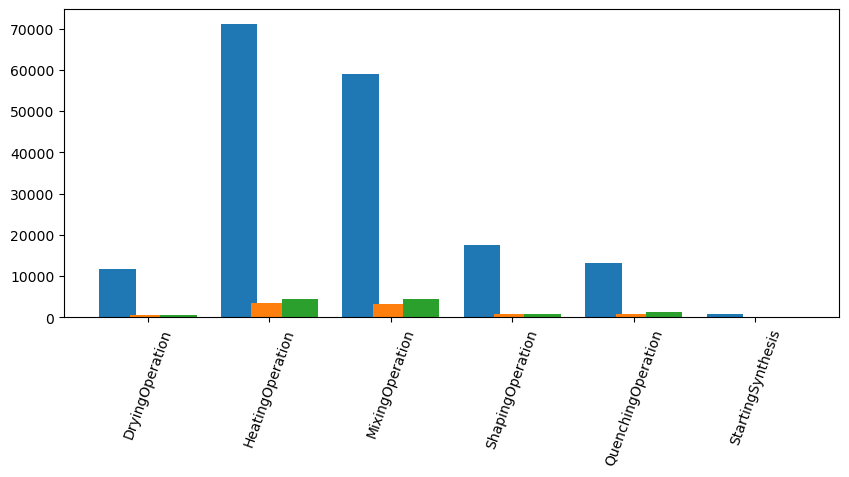

In [108]:
f, ax = plt.subplots(1,1,figsize=(10,4))
keys = list(operations['train_reactions'].keys())
for i, op in enumerate(operations.values()):
    for j, key in enumerate(keys):
        val = op.get(key)
        ax.bar(j+(i-1)*0.25, val, width=0.3, color=mpl.cm.tab10(i))
_ = ax.set_xticks(np.arange(len(keys)), labels=keys, rotation=70)

- Temp. and Time dist.

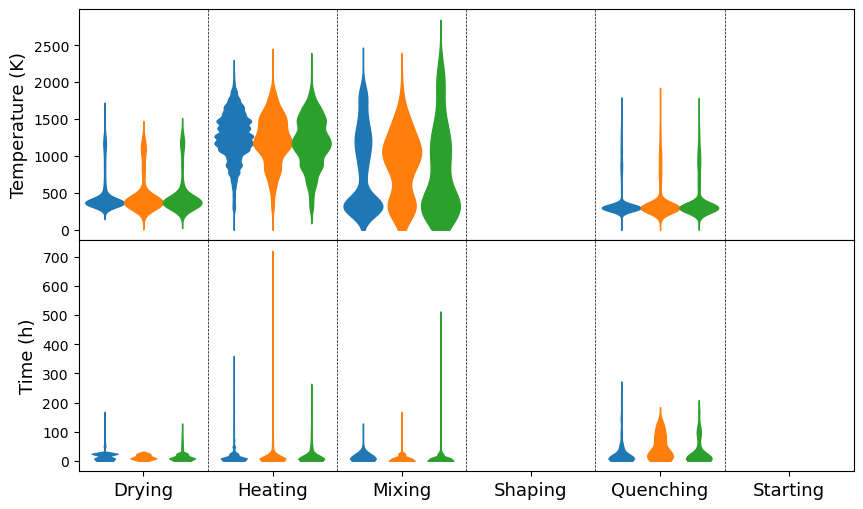

In [198]:
f, ax = plt.subplots(2,1,figsize=(10,6), sharex=True)
y = np.linspace(0,4000,500)
for i, ds in enumerate(operations.keys()):
    for j, key in enumerate(keys):
        t1 = temp_vals[ds][key]
        t2 = time_vals[ds][key]
        k = j + (i-1) * 0.3
        if len(t1) != 0:
            x = gaussian_kde(t1)(y)
            x = x/np.max(x) * 0.15
            m = x > 1e-4
            ax[0].fill_betweenx(y[m], -x[m]+k, x[m]+k, color=mpl.cm.tab10(i))
        if len(t2) != 0:
            x = gaussian_kde(t2)(y)
            x = x/np.max(x) * 0.1
            m = x > 1e-4
            ax[1].fill_betweenx(y[m], -x[m]+k, x[m]+k, color=mpl.cm.tab10(i))
for _ax in ax: 
    _ax.set_xlim([-0.5, 5.5])
    [_ax.axvline(i+0.5, ls='--', lw=0.5, color=[0,0,0]) for i in range(5)]
ax[1].set_xticks(np.arange(len(keys)), labels=[k.split('O')[0].split('Syn')[0] for k in keys], fontsize=13)
ax[0].set_ylabel('Temperature (K)', fontsize=13)
ax[1].set_ylabel('Time (h)', fontsize=13)
f.subplots_adjust(hspace=0)

- Heating Op. temp. & time dist.

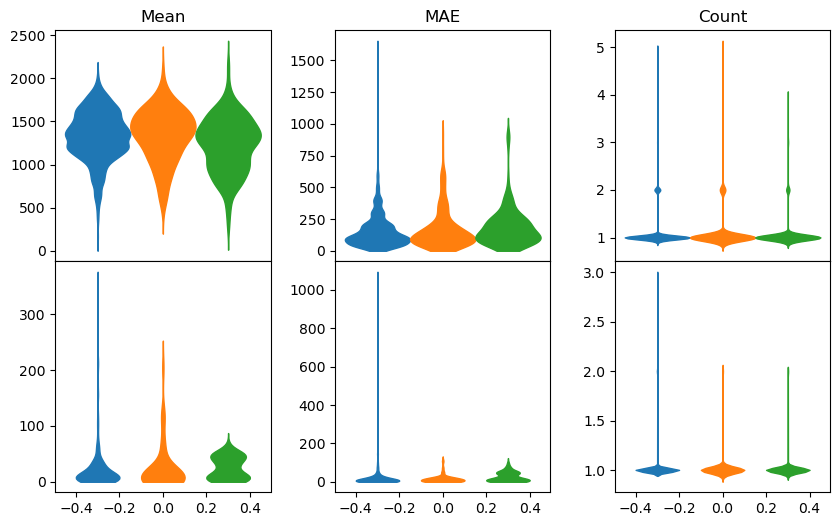

In [206]:
f, axs = plt.subplots(2,3,figsize=(10,6), sharex=True)
for i, ds in enumerate(operations.keys()):
    k = (i-1) * 0.3
    for j, vs in enumerate(np.array(temp_dist[ds]).T):
        y = np.linspace(0,3000,500)
        if j == 2:
            y = np.linspace(0,10,500)
        x = gaussian_kde(vs[vs != 0])(y)
        x = x/np.max(x) * 0.15
        m = x > 1e-4
        axs[0, j].fill_betweenx(y[m], -x[m]+k, x[m]+k, color=mpl.cm.tab10(i))
    for j, vs in enumerate(np.array(time_dist[ds]).T):
        y = np.linspace(0,1500,500)
        if j == 2:
            y = np.linspace(0,10,500)
        x = gaussian_kde(vs[vs != 0])(y)
        x = x/np.max(x) * 0.1
        m = x > 1e-4
        axs[1, j].fill_betweenx(y[m], -x[m]+k, x[m]+k, color=mpl.cm.tab10(i))
axs[0,0].set_title('Mean')
axs[0,1].set_title('MAE')
axs[0,2].set_title('Count')
f.subplots_adjust(hspace=0, wspace=0.3)

In [284]:
from pymatgen.core import Element

Element('Li').number

3

## Targets & Precursors

In [348]:
chem_format = '{}={:.3f}'
AllElements = TargetGroupElements + FunctionalGroupElements

count_ele = {e:[0,0,0] for e in sorted(AllElements, key=lambda x: Element(x).number)}
count_target = {}
count_target_system = {}
count_prec = {}
count_prec_system = {}
count_tgt_eles = {e:{'count':[0,0,0]} for e in sorted(TargetGroupElements, key=lambda x: Element(x).number)}
count_tgt_eles.update({'None':{'count':[0,0,0]}})
count_multiple_prec_case = {e:np.zeros((3,5)) for e in sorted(TargetGroupElements, key=lambda x: Element(x).number)}
count_multiple_prec_case.update({'None':np.zeros((3,5))})
for i, dataset in enumerate(parsed_data.values()):
    # loop over data
    for data in dataset:
        # get target material in string
        target_comp = {e:v for e,v in sorted(data['target_comp'].items(), key=lambda x: Element(x[0]).number)}
        prec_comps = [{e:v for e,v in sorted(prec_comp.items(), key=lambda x: Element(x[0]).number)} for prec_comp in data['precursor_comp']]
        
        target_string = '_'.join([chem_format.format(e,v) for e,v in target_comp.items() if v > 0.001])
        target_eles = tuple(list(target_comp.keys()))
        if target_string not in count_target.keys():
            count_target[target_string] = [0,0,0]
        count_target[target_string][i] += 1
        if target_eles not in count_target_system.keys():
            count_target_system[target_eles] = [0,0,0]
        count_target_system[target_eles][i] += 1

        _num_prec = {e:0 for e in target_comp.keys() if e in TargetGroupElements}
        _num_prec.update({'None':0})
        for prec_comp in prec_comps:
            prec_string = '_'.join([chem_format.format(e,v) for e,v in prec_comp.items() if v > 0.001])
            prec_eles = tuple(list(prec_comp.keys()))
            prec_fg_eles = tuple([e for e in prec_comp.keys() if e not in TargetGroupElements])
            prec_fg_comp_string = '_'.join([f'{v:.3f}' for e, v in prec_comp.items() if (e not in TargetGroupElements) and (v > 0.001)])
            prec_metal_eles = [e for e in prec_comp.keys() if e in TargetGroupElements]
            if len(prec_metal_eles) > 1: # if multiple metallic element
                print(prec_comp)
            prec_metal_ele = prec_metal_eles[0] if len(prec_metal_eles) != 0 else 'None'
            
            if prec_string not in count_prec.keys():
                count_prec[prec_string] = [0,0,0]
            count_prec[prec_string][i] += 1
            if prec_eles not in count_prec_system.keys():
                count_prec_system[prec_eles] = [0,0,0]
            count_prec_system[prec_eles][i] += 1
            if prec_fg_eles not in count_tgt_eles[prec_metal_ele].keys():
                count_tgt_eles[prec_metal_ele][prec_fg_eles] = {'count':[0,0,0], 'case':{}}
            if prec_fg_comp_string not in count_tgt_eles[prec_metal_ele][prec_fg_eles]['case'].keys():
                count_tgt_eles[prec_metal_ele][prec_fg_eles]['case'][prec_fg_comp_string] = [0,0,0]
            count_tgt_eles[prec_metal_ele]['count'][i] += 1
            count_tgt_eles[prec_metal_ele][prec_fg_eles]['count'][i] += 1
            count_tgt_eles[prec_metal_ele][prec_fg_eles]['case'][prec_fg_comp_string][i] += 1
            
            _num_prec[prec_metal_ele] += 1
        for e, v in _num_prec.items():
            if e == 'None' and v == 0: continue
            count_multiple_prec_case[e][i, v] += 1

- \# of target & precursors

In [320]:
print('Count by target composition', len(count_target))
print('Count by target element', len(count_target_system))
print('Count by precursor composition', len(count_prec))
print('Count by precursor element', len(count_prec_system))

fg_sys = []
for v in count_tgt_eles.values():
    for k in v.keys():
        if k not in fg_sys:
            if k == 'count': continue
            fg_sys.append(k)

print('Count by precursor functional group element', len(fg_sys))

Count by target composition 27854
Count by target element 9557
Count by precursor composition 1037
Count by precursor element 665
Count by precursor functional group element 59


- \# of elements in target compounds & precursors

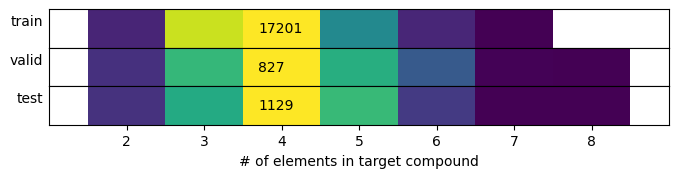

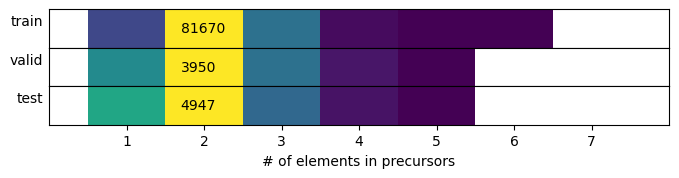

In [341]:
mat = np.zeros((3,10))
cmap = mpl.cm.viridis
cmap.set_under([1,1,1])
ylabels = ['train','valid','test']
for sys, count in count_target_system.items():
    n_ele = len(sys)
    mat[:, n_ele] += count
f, axs = plt.subplots(3,1,figsize=(8,1.5), sharex=True)
for ax, m, ylabel in zip(axs, mat, ylabels):
    ax.pcolormesh([m], cmap=cmap, vmin=1)
    ax.text(np.argmax(m)+0.2, 0.4, f'{np.max(m):.0f}')
    ax.set_xticks(np.arange(2,9) + 0.5, labels=[str(i) for i in range(2,9)])
    ax.set_xlim(1.5,9.5)
    ax.set_yticks([])
    ax.set_ylabel(ylabel, rotation=0, ha='right')
ax.set_xlabel('# of elements in target compound')
f.subplots_adjust(hspace=0)

mat = np.zeros((3,10))
for sys, count in count_prec_system.items():
    n_ele = len(sys)
    mat[:, n_ele] += count
f, axs = plt.subplots(3,1,figsize=(8,1.5), sharex=True)
for ax, m, ylabel in zip(axs, mat, ylabels):
    ax.pcolormesh([m], cmap=cmap, vmin=1)
    ax.text(np.argmax(m)+0.2, 0.4, f'{np.max(m):.0f}')
    ax.set_xticks(np.arange(1,8) + 0.5, labels=[str(i) for i in range(1,8)])
    ax.set_xlim(0.5,8.5)
    ax.set_yticks([])
    ax.set_ylabel(ylabel, rotation=0, ha='right')
ax.set_xlabel('# of elements in precursors')
f.subplots_adjust(hspace=0)


quatenary가 가장 많음. 

- \# of precursors used for metal element in single reaction

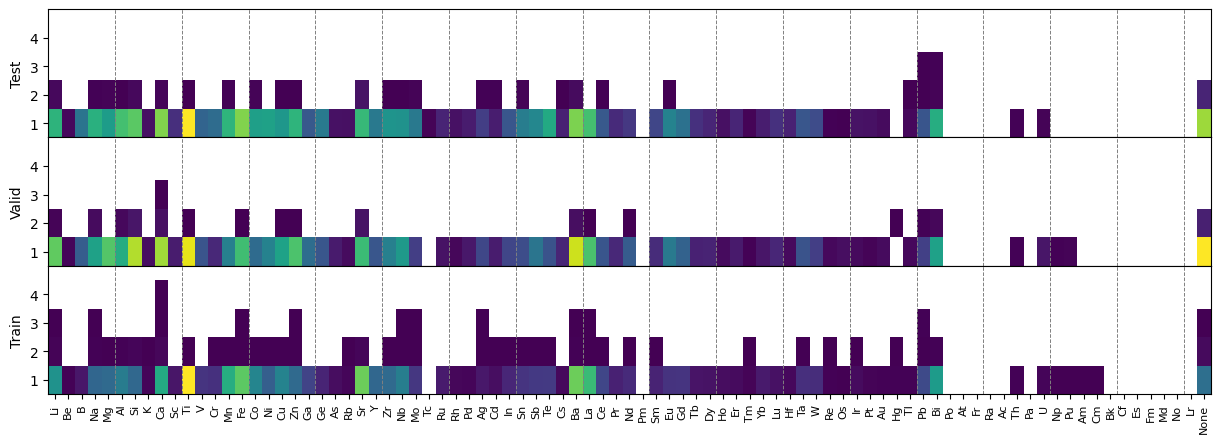

In [286]:
f, axs = plt.subplots(3,1,figsize=(15,5), sharex=True)
cmap = mpl.cm.viridis
cmap.set_under([1,1,1])
ele = list(count_multiple_prec_case.keys())
mat = np.array([v for v in count_multiple_prec_case.values()]).transpose(1,0,2)
for ax, v in zip(axs[::-1], mat):
    ax.pcolormesh(v.T, vmin=1, cmap=cmap)
    [ax.axvline(i*5, ls='--', color=[0.5, 0.5, 0.5], lw=0.7) for i in range(1,18)]
    ax.set_yticks(np.arange(1,5)+0.5, labels=[str(i) for i in range(1,5)])
    ax.set_ylim([1, 5.5])
axs[2].set_xticks(np.arange(len(ele))+0.5, labels=ele, rotation=90, fontsize=8)
axs[0].set_ylabel('Test')
axs[1].set_ylabel('Valid')
axs[2].set_ylabel('Train')
f.subplots_adjust(hspace=0)

2종 이상의 프리커서가 사용된 경우 다수 존재함

- \# of functional groups (by consisting elements) used for precursors

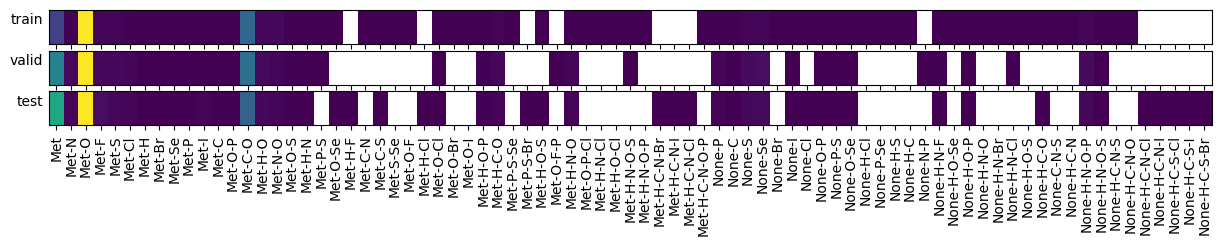

In [375]:
prec_system = {}
for metal, v in count_tgt_eles.items():
    ele = ('Met',)
    if metal == 'None':
        ele = ('None',)
    for fg_sys, v2 in v.items():
        if fg_sys == 'count': continue
        key = ele + fg_sys
        if key not in prec_system.keys():
            prec_system[key] = np.zeros(3)
        prec_system[key] += np.array(v2['count'])

prec_system = {k:v for k,v in sorted(sorted(prec_system.items(), key=lambda x: len(x[0])), key=lambda x: x[0][0])}
xticks = ['-'.join(list(k)) for k in prec_system.keys()]
mat = np.array(list(prec_system.values())).T

cmap = mpl.cm.viridis
cmap.set_under([1,1,1])
ylabels = ['train','valid','test']
f, axs = plt.subplots(3,1,figsize=(15,1.5), sharex=True)
for ax, m, ylabel in zip(axs, mat, ylabels):
#    m[m == 0] = 1e-5
#    m = np.log10(m)
    ax.pcolormesh([m], cmap=cmap, vmin=1)
#    ax.text(np.argmax(m)+0.2, 0.4, f'{np.max(m):.0f}')
    ax.set_xticks(np.arange(len(xticks)) + 0.5, labels=xticks, rotation=90)
    ax.set_ylabel(ylabel, rotation=0, ha='right')
    ax.set_yticks([])

In [ ]:
f, axs = plt.subplots(3,1,figsize=(15,5), sharex=True)
cmap = mpl.cm.viridis
cmap.set_under([1,1,1])

fg_sys = []
for v in count_tgt_eles.values():
    for k in v.keys():
        if k not in fg_sys:
            if k == 'count': continue
            fg_sys.append(k)
sorted(sorted(fg_sys), key=lambda x: len(x))

ele = list(count_multiple_prec_case.keys())
mat = np.array([v for v in count_multiple_prec_case.values()]).transpose(1,0,2)
for ax, v in zip(axs[::-1], mat):
    ax.pcolormesh(v.T, vmin=1, cmap=cmap)
    [ax.axvline(i*5, ls='--', color=[0.5, 0.5, 0.5], lw=0.7) for i in range(1,18)]
    ax.set_yticks(np.arange(1,5)+0.5, labels=[str(i) for i in range(1,5)])
    ax.set_ylim([1, 5.5])
axs[2].set_xticks(np.arange(len(ele))+0.5, labels=ele, rotation=90, fontsize=8)
axs[0].set_ylabel('Test')
axs[1].set_ylabel('Valid')
axs[2].set_ylabel('Train')
f.subplots_adjust(hspace=0)

## precursors

In [117]:
n_train = 44736
i_valid = n_train + 2254 
targets = []
mat_by_target = {}
mat_by_prec = {}
count_ele = {}
count_sys = {}
count_tgt = {}
count_pre = {}
count_cat = {}
count_mul_cat = {}
count_pre_ele = {}
count_pre_an  = {}
n_maxs = [0, 0]
has_temp_op = {}
#units = {}
temp_op_div = {}
time_op_div = {}
temp_time_histmap = {}
temp_time_pairs = {}
for k, dataset in parsed_data.items():
#    if 'train' in k: continue
    count_ele[k] = {e:0 for e in TargetGroupElements + FunctionalGroupElements}
    count_sys[k] = np.zeros((12,12))
    count_cat[k] = np.zeros((10,10))
    count_mul_cat[k] = np.zeros((74,8))
    count_pre_ele[k] = {}
    count_pre_an[k] = {}
    count_tgt[k] = {}
    count_pre[k] = {}
    has_temp_op[k] = np.zeros(11)
    temp_op_div[k] = [[] for _ in range(11)] 
    time_op_div[k] = [[] for _ in range(11)] 
    temp_time_histmap[k] = np.zeros((11,11))
    temp_time_pairs[k] = [[], []]
    temp_mask = np.linspace(0, 1e4, 100)
    time_mask = np.linspace(0, 1e2, 100)
    
    # loop over data
    for data in dataset:
        has_op = 0
        # get target material in string
        target = '_'.join([chem_format.format(e,v) for e,v in sorted(data['target_comp'].items(), key=lambda x: x[0]) if v > 0.001])
        targets.append(target)
        if target not in count_tgt[k].keys():
            count_tgt[k][target] = 0
        count_tgt[k][target] += 1
#        if len(data['target_comp']) > 6:
#            print(data['target_comp'])
        precursor = []
        prec_eles = []
        # get precursor materials in string
        for prec in data['precursor_comp']:
            prec_ = '_'.join([f'{e}+{v:.3f}' for e,v in sorted(prec.items(), key=lambda x: x[0]) if v > 0.001])
            if prec_ not in count_pre[k].keys():
                count_pre[k][prec_] = 0
            count_pre[k][prec_] += 1
            for e, _ in prec.items():
                prec_eles.append(e)
                # count element
                count_ele[k][e] += 1
            precursor.append(prec_)
            if prec_ not in mat_by_prec.keys():
                mat_by_prec[prec_] = {'count':0, 'ops':[]}
            mat_by_prec[prec_]['count'] += 1
            # cations & anions (with H, P) in precursors
            pe = [e for e in prec.keys()] # precursor elements
            # cation
            pe_cat_chem = tuple([e for e in sorted(pe, key=lambda x: x) if e in TargetGroupElements])
            if pe_cat_chem not in count_pre_ele[k].keys():
                count_pre_ele[k][pe_cat_chem] = {'count':0, 'anions':{}}
            
            # anion
            pe_an = {e:v for e,v in sorted(prec.items(), key=lambda x: x) if (v > 0.001) and e in FunctionalGroupElements}
            pe_an_chem = tuple(list(pe_an.keys()))
            norm_ = 1 if len(pe_an_chem) == 0 else np.min(list(pe_an.values()))
            pe_an_val  = ' '.join([f'{v/norm_:.3f}' for v in pe_an.values()])
            
            # update by cation
            if pe_an_chem not in count_pre_ele[k][pe_cat_chem]['anions'].keys():
                count_pre_ele[k][pe_cat_chem]['anions'][pe_an_chem] = {'count':0, 'case':{}}
            count_pre_ele[k][pe_cat_chem]['count'] += 1
            count_pre_ele[k][pe_cat_chem]['anions'][pe_an_chem]['count'] += 1
            
            if pe_an_val not in count_pre_ele[k][pe_cat_chem]['anions'][pe_an_chem]['case'].keys():
                count_pre_ele[k][pe_cat_chem]['anions'][pe_an_chem]['case'][pe_an_val] = 0
            count_pre_ele[k][pe_cat_chem]['anions'][pe_an_chem]['case'][pe_an_val] += 1

            # update by anion
            if pe_an_chem not in count_pre_an[k].keys():
                count_pre_an[k][pe_an_chem] = {'count':0, 'case':{}}
            if pe_an_val not in count_pre_an[k][pe_an_chem]['case'].keys():
                count_pre_an[k][pe_an_chem]['case'][pe_an_val] = 0
            count_pre_an[k][pe_an_chem]['count'] += 1
            count_pre_an[k][pe_an_chem]['case'][pe_an_val] += 1
            
        view_info = False
        for e, c in zip(*np.unique(prec_eles, return_counts=True)):
            if (ele_mapper[e] > 73) or (e in ['H','P']): continue
            count_mul_cat[k][ele_mapper[e], c] += 1
            if c > 2:
                view_info = True
#        if view_info: 
#            print(k, target, precursor)
        # get number of used elements
        n_target_ele = len([e for e in data['target_comp']])
        n_prec_ele = len([e for e in set(prec_eles)])
        count_sys[k][n_target_ele, n_prec_ele] += 1

        # get number of used cation
        n_target_ele = len([e for e in data['target_comp'] if (ele_mapper[e] < 74) and (e not in ['H','P'])])
        n_prec_ele = len([e for e in set(prec_eles) if (ele_mapper[e] < 74) and (e not in ['H','P'])])
        count_cat[k][n_target_ele, n_prec_ele] += 1

        precursor_ = '*'.join(precursor)
        if target not in mat_by_target.keys(): 
            mat_by_target[target] = {'count':0, 'ops':{}}
        if precursor_ not in mat_by_target[target]['ops'].keys():
            mat_by_target[target]['ops'][precursor_] = {'count':0, 'conditions':[]}
        mat_by_target[target]['count'] += 1
        mat_by_target[target]['ops'][precursor_]['count'] += 1


KeyError: 'units'

In [134]:
for k, v in count_pre.items():
    for k2, v2 in sorted(v.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(k, v2, k2)
    print(k, np.sum([v_ < 5 for v_ in v.values()]), len(v))

train_reactions 8374 Ti+0.333_O+0.667
train_reactions 6544 Sr+0.200_C+0.200_O+0.600
train_reactions 6451 Ba+0.200_C+0.200_O+0.600
train_reactions 5751 La+0.400_O+0.600
train_reactions 5560 Fe+0.400_O+0.600
train_reactions 4983 Ca+0.200_C+0.200_O+0.600
train_reactions 4310 Bi+0.400_O+0.600
train_reactions 3716 Nb+0.286_O+0.714
train_reactions 3191 Li+0.333_C+0.167_O+0.500
train_reactions 2876 Y+0.400_O+0.600
train_reactions 466 941
val_reactions 295 Ca+0.200_C+0.200_O+0.600
val_reactions 289 Ba+0.200_C+0.200_O+0.600
val_reactions 280 Si+0.333_O+0.667
val_reactions 278 Ti+0.333_O+0.667
val_reactions 238 La+0.400_O+0.600
val_reactions 230 Zn+0.500_O+0.500
val_reactions 229 Sr+0.200_C+0.200_O+0.600
val_reactions 188 Li+0.333_C+0.167_O+0.500
val_reactions 184 Nb+0.286_O+0.714
val_reactions 160 Na+0.333_C+0.167_O+0.500
val_reactions 194 361
test_reactions 285 Ba+0.200_C+0.200_O+0.600
test_reactions 275 Ti+0.333_O+0.667
test_reactions 272 Sr+0.200_C+0.200_O+0.600
test_reactions 263 Si+0.333_O

In [147]:
fg_list = []
for v in count_pre_an.values():
    for k in v.keys():
        if k not in fg_list:
            fg_list.append(k)
print(len(fg_list))
count_pre_cat_fg_map = {}
for k,v in count_pre_ele.items():
    count_pre_cat_fg_map[k] = np.zeros((75, len(fg_list)))
    for k2, v2 in v.items():
        if len(k2) == 0:
            i = 0
        else:
            i = ele_mapper[k2[0]]+1
        for k3, v3 in v2['anions'].items():
            j = fg_list.index(k3)
            count_pre_cat_fg_map[k][i, j] += v3['count']

59


In [144]:
for k1, v1 in count_pre_ele.items():
    for k2, v2 in v1.items():
        for k3, v3 in v2['anions'].items():
            if len(v3['case']) != 1:
                print(k1, k2, k3, v3)

train_reactions ('Y',) ('C', 'O') {'count': 4, 'case': {'1.000 3.000': 2, '1.000 2.000': 2}}
train_reactions ('Y',) ('H', 'C', 'O') {'count': 2, 'case': {'7.000 3.000 1.000': 1, '1.500 1.000 1.000': 1}}
train_reactions ('Si',) ('H', 'O') {'count': 44, 'case': {'1.000 1.000': 3, '1.000 1.500': 41}}
train_reactions ('Al',) ('H', 'O') {'count': 192, 'case': {'1.000 1.000': 183, '1.000 2.000': 9}}
train_reactions ('Al',) ('N', 'O') {'count': 88, 'case': {'1.000 3.000': 87, '1.000 1.000': 1}}
train_reactions ('Al',) ('H', 'C', 'O') {'count': 10, 'case': {'2.333 1.000 1.000': 3, '2.500 1.000 2.000': 3, '1.750 1.000 1.250': 4}}
train_reactions ('Al',) ('P', 'O') {'count': 3, 'case': {'1.000 4.000': 1, '1.000 3.000': 2}}
train_reactions ('Zr',) ('N', 'O') {'count': 32, 'case': {'1.000 3.500': 20, '1.000 4.000': 1, '1.000 3.333': 1, '1.000 3.000': 10}}
train_reactions ('Zr',) ('H', 'C', 'O') {'count': 5, 'case': {'4.000 2.500 1.000': 2, '9.000 4.000 1.000': 2, '1.500 1.000 1.000': 1}}
train_rea

["('O',) : 78466.0", "('C', 'O') : 25850.0", '() : 15533.0', "('H', 'O') : 1715.0", "('N', 'O') : 1681.0"]
["('O',) : 70", '() : 68', "('N', 'O') : 43", "('S',) : 42", "('F',) : 37"]
["('O',) : 3578.0", '() : 1589.0', "('C', 'O') : 1274.0", "('S',) : 182.0", "('Se',) : 148.0"]
['() : 63', "('O',) : 61", "('S',) : 23", "('N', 'O') : 20", "('Cl',) : 16"]
["('O',) : 4495.0", '() : 2659.0', "('C', 'O') : 1394.0", "('S',) : 193.0", "('F',) : 153.0"]
["('O',) : 64", '() : 61', "('S',) : 26", "('F',) : 25", "('Cl',) : 25"]


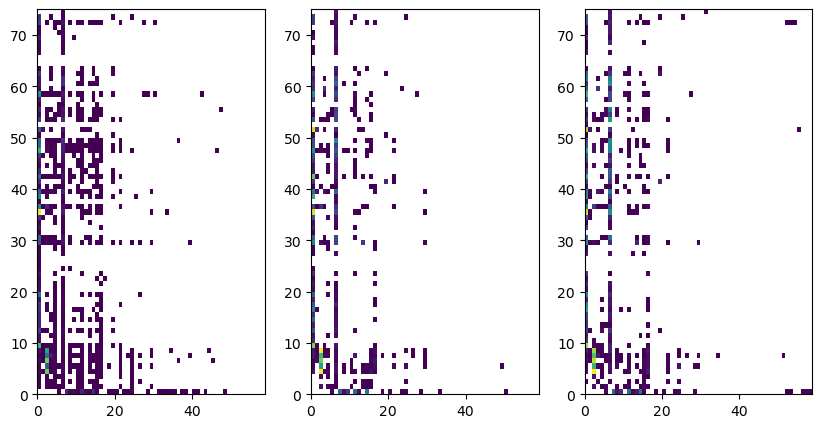

In [123]:
f, axs = plt.subplots(1,3,figsize=(10,5))
for ax, v in zip(axs, count_pre_cat_fg_map.values()):
    ax.pcolormesh(v, cmap=cmap, vmin=1)
    fg_usage = v.sum(0)
    fg_freq = (v != 0).sum(0)
    print([f'{fg_list[i]} : {fg_usage[i]}' for i in np.argsort(fg_usage)[-5:][::-1]])
    print([f'{fg_list[i]} : {fg_freq[i]}' for i in np.argsort(fg_freq)[-5:][::-1]])

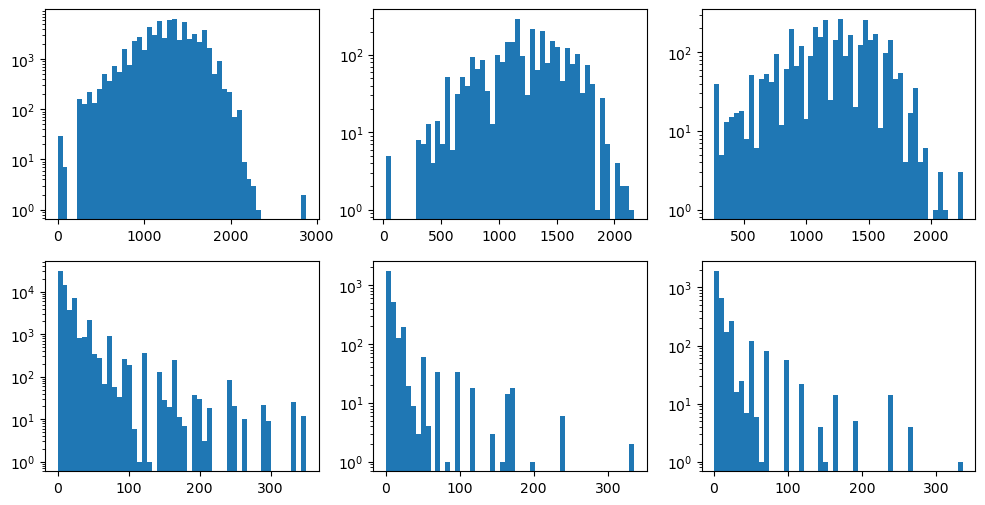

In [124]:
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = mpl.cm.viridis
cmap.set_under([1,1,1])
f, axs = plt.subplots(2,3,figsize=(12,6))
for ax, (k,v) in zip(axs.T, temp_time_pairs.items()):
    ax[0].hist(v[0], bins=50)
    info = ax[1].hist(v[1], bins=50)
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
#    ax.set_xticks(np.arange(5)*2 + 0.5, labels=[str(i*2) for i in range(5)])
#    ax.set_yticks(np.arange(6)*2 + 0.5, labels=[str(i*2) for i in range(6)])
#    ax.set_yticks()

In [146]:
ele_mapper = json.load(open('../dump/ele_mapper.json'))
n_ele = len(ele_mapper)

def fnc_feat(ele_dict):
    feat = np.zeros(n_ele, dtype=np.float32)
    for e, v in ele_dict.items():
        feat[ele_mapper[e]] = v
    return feat

tgt_feats = []
pre_feats = []
for ds, dataset in parsed_data.items():
    for data in dataset:
        tgt_feats.append(fnc_feat(data['target_comp']))
        pre_feats.append(np.vstack([fnc_feat(comp) for comp in data['precursors_comp']]))
tgt_feats = np.vstack(tgt_feats)

In [150]:
dist = np.array([np.square(tgt_feats - f1.reshape(1,-1)).sum(1) for f1 in tgt_feats])

In [278]:
for ds, dataset in parsed_data.items():
    print(len(dataset))

44736
2254
2934


In [317]:
new_material_mask = np.sum(dist[:n_train, n_train:] < 0.1, 0)
np.sum((new_material_mask == 0)[:2254]), np.sum((new_material_mask == 0)[2254:])

(133, 265)

In [311]:
new_material_mask = np.sum(dist[:n_train, n_train:] < 0.1, 0)
print(np.sum(new_material_mask == 0))
for i in np.where(new_material_mask == 0)[0]:
    print(f'target: {n_train+i:5d} / {targets[n_train+i]}')
    for j in np.argsort(dist[n_train:, :n_train][i])[:5]:
        print(f'Sim: {j:5d} / {dist[n_train+i,j]:.5f} / {targets[j]}')
    

398
target: 44760 / Mg+0.33_Zn+0.33_Pd+0.33
Sim:   992 / 0.15280 / Sm+0.08_Mg+0.42_Zn+0.50
Sim: 18652 / 0.18713 / Mg+0.60_Zr+0.07_Zn+0.33
Sim:  8875 / 0.22222 / Mg+0.33_Zn+0.33_O+0.33
Sim: 12986 / 0.22222 / Y+0.33_Mg+0.33_Zn+0.33
Sim: 28479 / 0.22222 / Mg+0.33_Zn+0.33_Sn+0.33
target: 44780 / Ca+0.33_Al+0.67
Sim: 42234 / 0.14222 / Zr+0.10_Ti+0.10_Al+0.70_V+0.10
Sim:  5759 / 0.14597 / Al+0.70_Co+0.15_Cu+0.08_Ni+0.08
Sim:  5764 / 0.14597 / Al+0.70_Co+0.08_Cu+0.08_Ni+0.15
Sim:  5758 / 0.14722 / Al+0.70_Co+0.15_Cu+0.05_Ni+0.10
Sim:  5760 / 0.14722 / Al+0.70_Co+0.15_Cu+0.10_Ni+0.05
target: 44898 / Mg+0.50_In+0.50
Sim: 12988 / 0.16667 / Y+0.33_Mg+0.33_In+0.33
Sim:  9214 / 0.32833 / Mg+0.58_Al+0.08_Cr+0.10_Ni+0.23
Sim: 26694 / 0.33673 / Ce+0.14_In+0.71_Co+0.14
Sim: 16666 / 0.33681 / Mg+0.67_Mn+0.12_Ni+0.21
Sim: 12805 / 0.33699 / Gd+0.20_Mg+0.69_Zn+0.12
target: 44901 / Mg+0.50_S+0.50
Sim: 26429 / 0.19959 / Mg+0.14_In+0.26_Fe+0.03_S+0.57
Sim: 26428 / 0.20653 / Mg+0.14_In+0.27_Fe+0.01_S+0.57
Sim:

In [325]:
for k,v in sorted(count_ele.items(), key=lambda x: x[1], reverse=True):
    print(k, v)

O 11657
C 2861
Ti 781
H 739
Ba 734
Ca 706
Si 701
Sr 613
Fe 602
Li 578
La 562
N 558
Al 546
Zn 543
Mg 512
Bi 509
Na 509
S 450
Cu 444
Mn 442
P 418
Nb 414
Ni 406
Zr 383
Co 377
Te 352
Eu 342
Sb 339
Se 285
Sn 276
Ge 274
Gd 274
Y 272
B 272
Mo 249
Ga 246
F 240
V 231
Ce 218
Ta 208
Pb 196
In 191
Cr 191
Nd 177
W 166
Ag 163
Sm 135
Cl 130
Lu 100
Tb 95
Pr 93
Sc 87
Cs 83
Dy 81
I 74
Er 71
Cd 70
Ru 61
Pd 58
Yb 57
Hf 50
As 48
K 33
Ir 32
Rb 31
Ho 30
Rh 27
Pt 26
U 26
Au 26
Tl 24
Br 24
Be 17
Os 17
Re 13
Tm 9
Th 7
Tc 6
Pu 4
Np 3
Hg 2


In [153]:
from sklearn.manifold import TSNE
tsne = TSNE()
tvec =tsne.fit_transform(tgt_feats)

In [326]:
num_sets = np.array([len(v['ops']) for v in mat_by_target.values()])
np.unique(num_sets, return_counts=True)

(array([1, 2, 3, 4, 5, 6]), array([3711,  162,   20,    8,    2,    1]))

In [330]:
mat_by_target

{'Ce+0.01_Co+0.25_Sb+0.74': {'count': 1,
  'ops': {'Ce+1.00*Co+1.00*Sb+1.00': {'count': 1,
    'conditions': [array([1373.15]), [], array([1023.15]), []]}}},
 'Ce+0.02_Co+0.25_Sb+0.74': {'count': 1,
  'ops': {'Ce+1.00*Co+1.00*Sb+1.00': {'count': 1,
    'conditions': [array([1373.15]), [], array([1023.15]), []]}}},
 'Mg+0.34_Ag+0.33_Sb+0.33': {'count': 11,
  'ops': {'Mg+1.00*Ag+1.00*Sb+1.00': {'count': 6,
    'conditions': [array([575.]), array([1273.]), [], [], array([575.])]},
   'Na+1.00*Mg+1.00*Ag+1.00*Sb+1.00': {'count': 2, 'conditions': []},
   'Li+1.00*Mg+1.00*Ag+1.00*Sb+1.00': {'count': 2, 'conditions': []},
   'Yb+1.00*Mg+1.00*Ag+1.00*Sb+1.00': {'count': 1, 'conditions': []}}},
 'Ba+0.07_Ti+0.07_Fe+0.13_Bi+0.14_O+0.60': {'count': 2,
  'ops': {'Ba+0.20_C+0.20_O+0.60*Ti+0.33_O+0.67*Fe+0.40_O+0.60*Bi+0.40_O+0.60': {'count': 2,
    'conditions': [array([973.15]), array([1283.15, 1253.15])]}}},
 'Ba+0.05_Ti+0.05_Fe+0.15_Bi+0.11_O+0.63': {'count': 1,
  'ops': {'Ba+0.20_C+0.20_O+0.60*

In [334]:
for target, dat in mat_by_target.items():
    if len(dat['ops']) == 1: continue
    if dat['count'] == 1: continue
#        print(target, dat['count'])
    cs = {}
    for prec, dat2 in dat['ops'].items():
#            print('\t{}\t{}\t{}'.format(dat2['count'], len(dat2['conditions']), prec))
        if len(dat2['conditions']) != 0:
            c = np.hstack(dat2['conditions'])
            if len(set(c)) > 5:
                cs[prec] = c
#                    print('\t{}\t\t{:.3f} / {:.3f} / {:.3f}'.format(len(c), np.min(c), np.max(c), np.median(c)))
    print(len(cs), cs)
    if len(cs) > 1:
        f, ax = plt.subplots(1, 1, figsize=(10, 3))
        f.suptitle(target)
        for prec, t in cs.items():                
            g = gaussian_kde(t, bw_method=0.5)
            ax.plot(x, g(x), label=f'{len(t)} / {prec}')
        ax.legend(loc='upper right')
            

0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
0 {}
1 {'Li+0.33_C+0.17_O+0.50*Mg+0.50_O+0.50*Nb+0.29_O+0.71': array([1323.15, 1323.15, 1123.15, 1223.15, 1223.15, 1473.15, 1348.15,
       1223.15,  873.15, 1473.15, 1373.15,  773.15, 1173.15, 1323.15,
       1173.15, 1323.15, 1273.15, 1273.15, 1123.15, 1223.15, 1273.15,
       1348.15, 1323.15, 1423.15, 1398.15, 1373.15, 1273.15, 1348.15,
       1323.15, 1423.15, 1398.15, 1373.15, 1273.15, 1348.15, 1323.15,
       1423.15, 1398.15, 1373.15, 1273.15, 1348.15, 1323.15, 1423.15,
       1398.15, 1373.15, 1273.15, 1348.15, 1323.15, 1423.15, 1398.15,
       1373.15, 1223.15,  823.15, 1498.15, 1298.15, 1273.15, 1298.15,
       1323.15, 1423.15])}
1 {'Ti+0.33_O+0.67*Zn+0.50_O+0.50*Ni+0.50_O+0.50': array([1073.15, 1273.15, 1873.15, 1723.15, 1823.15, 1173.15

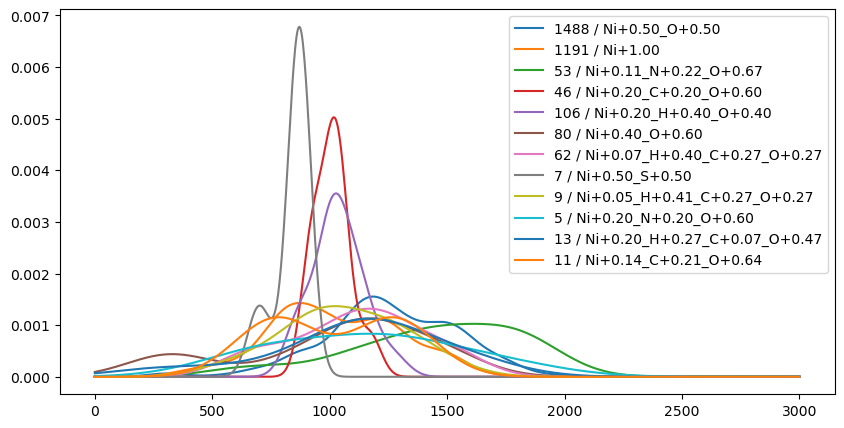

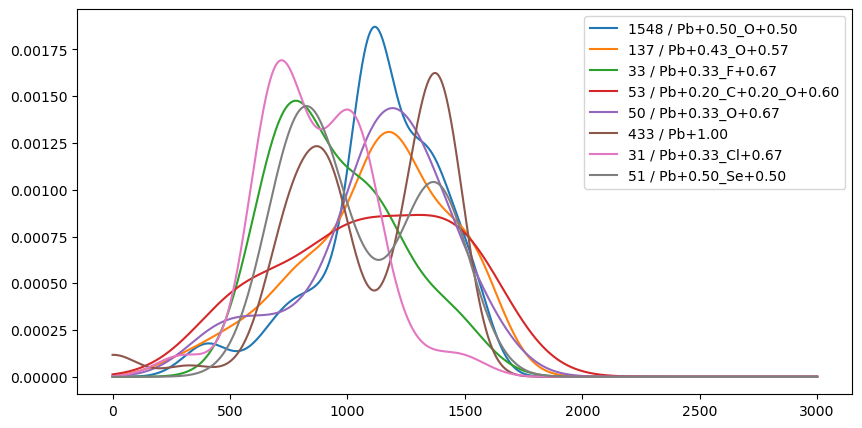

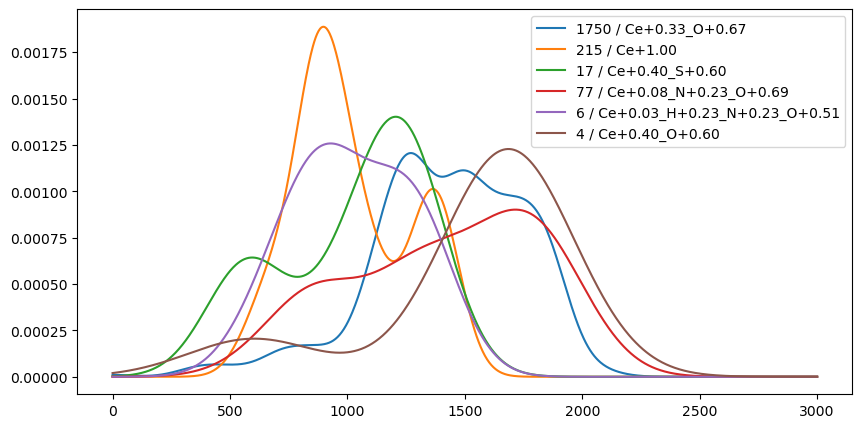

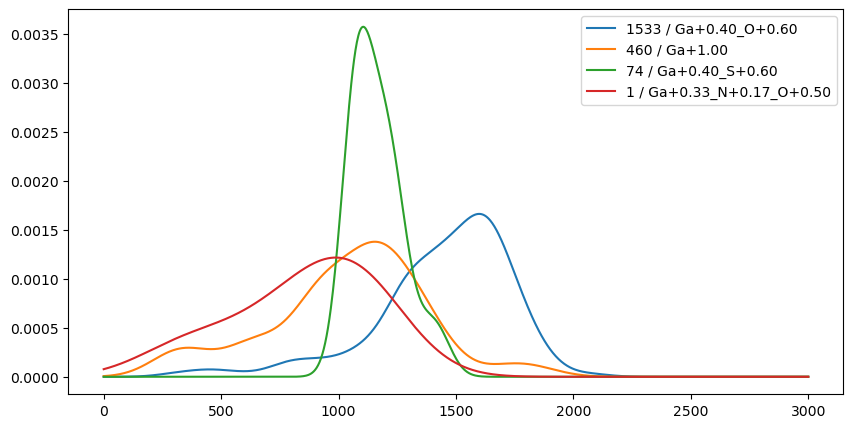

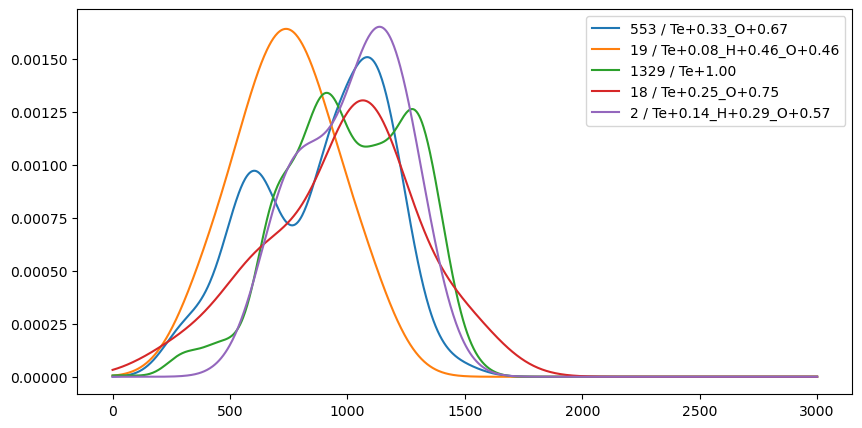

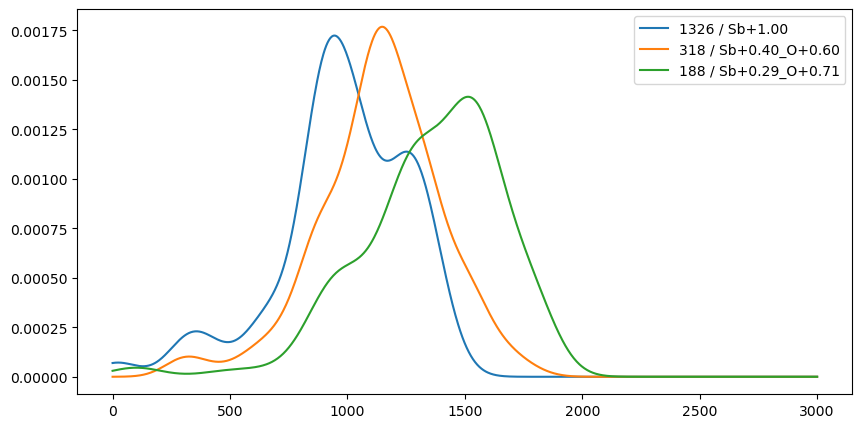

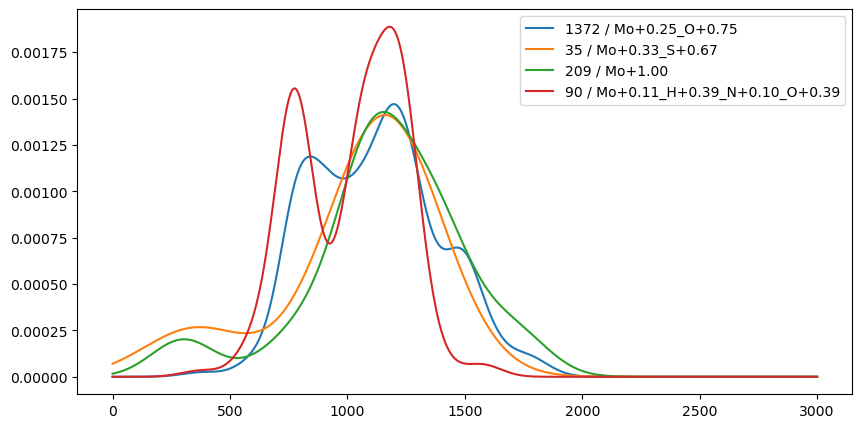

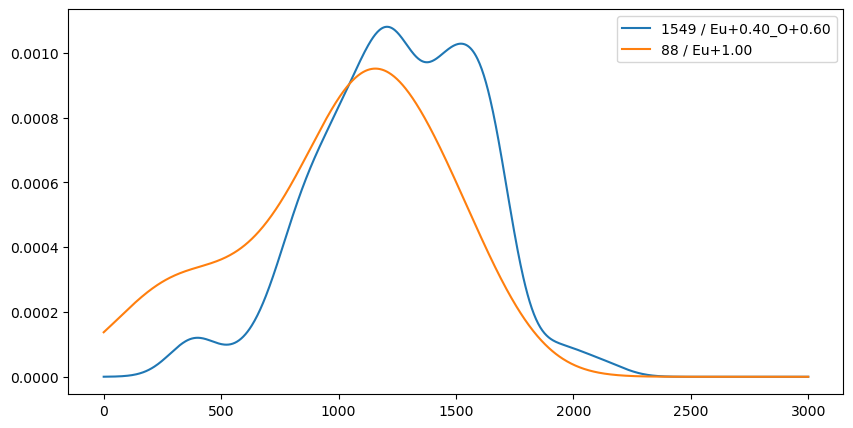

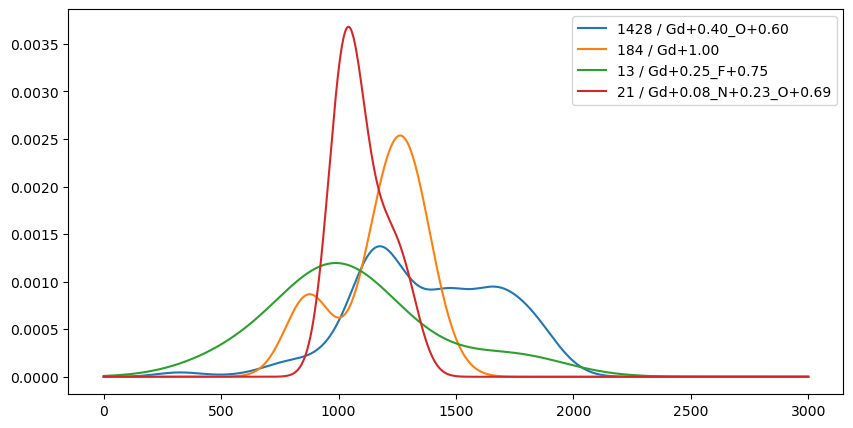

In [319]:
view_eles = ['Ti', 'Sr', 'Ba', 'Fe', 'La', 'Ca', 'Mn', 'Bi', 'Li']
view_eles = ['Ni','Pb','Ce','Ga','Te','Sb','Mo','Eu','Gd',]

#mat_by_prec = {k:v for k,v in sorted(mat_by_prec.items(), key=lambda x: x[1]['count'], reverse=True)}
for view_ele in view_eles:
    f, ax = plt.subplots(1,1,figsize=(10,5))
    for k,v in mat_by_prec.items():
        if view_ele not in k: continue
        if len(v['ops']) < 5: continue
        vs = np.hstack(v['ops'])
        if len(vs) < 5: continue
        g = gaussian_kde(vs)
        ax.plot(x, g(x), label=f'{v["count"]} / {k}')
    ax.legend(loc='upper right')

In [256]:
{k:v for k,v in sorted(count_ele.items(), key=lambda x: x[1], reverse=True)}

{'O': 122581,
 'C': 29997,
 'Ti': 9975,
 'Sr': 7944,
 'Ba': 7929,
 'Fe': 7483,
 'La': 6777,
 'Ca': 6660,
 'Mn': 6147,
 'Bi': 5559,
 'Li': 5419,
 'H': 5257,
 'Cu': 4573,
 'Co': 4571,
 'Al': 4478,
 'Nb': 4315,
 'N': 4120,
 'Si': 4029,
 'Zn': 3720,
 'Mg': 3686,
 'Na': 3586,
 'Zr': 3505,
 'Y': 3286,
 'Ni': 3137,
 'P': 2494,
 'Pb': 2476,
 'S': 2286,
 'Ce': 2125,
 'Ga': 2097,
 'Te': 1926,
 'Sb': 1863,
 'Mo': 1787,
 'Eu': 1685,
 'Gd': 1652,
 'Sn': 1652,
 'V': 1600,
 'Se': 1515,
 'Cr': 1461,
 'Ta': 1442,
 'W': 1327,
 'Nd': 1255,
 'Ge': 1201,
 'In': 1184,
 'F': 1029,
 'Sm': 1025,
 'Pr': 921,
 'Ag': 837,
 'B': 833,
 'Ru': 730,
 'Yb': 676,
 'Sc': 605,
 'Tb': 595,
 'Cl': 565,
 'Dy': 540,
 'Lu': 525,
 'Cd': 398,
 'Er': 348,
 'As': 335,
 'Ho': 317,
 'Ir': 310,
 'Cs': 276,
 'Hf': 258,
 'I': 191,
 'Pd': 190,
 'K': 175,
 'Rh': 175,
 'Rb': 147,
 'U': 143,
 'Br': 137,
 'Pt': 101,
 'Tm': 86,
 'Re': 83,
 'Au': 80,
 'Tl': 77,
 'Be': 56,
 'Os': 49,
 'Th': 49,
 'Hg': 47,
 'Pu': 28,
 'Np': 12,
 'Tc': 6,
 'Am':

In [253]:
mat_by_prec

{'Y+0.40_O+0.60': {'count': 3101,
  'ops': [array([1873.15, 2123.15]),
   array([2073.15]),
   array([2023.15]),
   array([1673.15]),
   array([1123.]),
   array([1213., 1183.]),
   array([1123.]),
   array([1213., 1183.]),
   array([1123.]),
   array([1213., 1183.]),
   array([1223.15]),
   array([1223.15]),
   array([1223.15]),
   array([1223.15]),
   [],
   array([1573.15]),
   array([1773.15, 1973.15]),
   [],
   array([1673.15]),
   array([1523.15]),
   array([1923.15]),
   array([1523.15]),
   array([1923.15]),
   array([1273.15]),
   array([1473.15]),
   array([1773.15]),
   array([1473.15]),
   [],
   array([1203.15]),
   [],
   [],
   array([1323.15]),
   array([1173.15]),
   array([1173.15]),
   array([1173.15]),
   array([823.15]),
   array([1873.15]),
   array([1123.15]),
   array([1773.15]),
   [],
   array([1673.15, 1973.15]),
   array([1698.15, 1773.15]),
   array([1673.15, 1973.15]),
   array([1698.15, 1773.15]),
   array([1673.15, 1973.15]),
   array([1698.15, 1773.15]

In [202]:
for k, v in mat['Ba+0.031250_Fe+0.375000_O+0.593750']['ops'].items():
    print(k, v['count'])

Ba+0.200000_C+0.200000_O+0.600000*Fe+0.400000_O+0.600000 107
Ba+0.200000_C+0.200000_O+0.600000*Fe+0.333333_C+0.166667_O+0.500000 1
Ba+0.333333_O+0.666667*Fe+0.400000_O+0.600000 4
Ba+0.200000_C+0.200000_O+0.600000*Fe+0.142857_C+0.285714_O+0.571429 1
Ba+0.500000_O+0.500000*Fe+0.400000_O+0.600000 2
Ba+0.333333_O+0.666667*Fe+0.142857_C+0.285714_O+0.571429*H+0.666667_C+0.333333 2
Ba+0.066667_H+0.400000_C+0.266667_O+0.266667*Fe+0.400000_O+0.600000 2


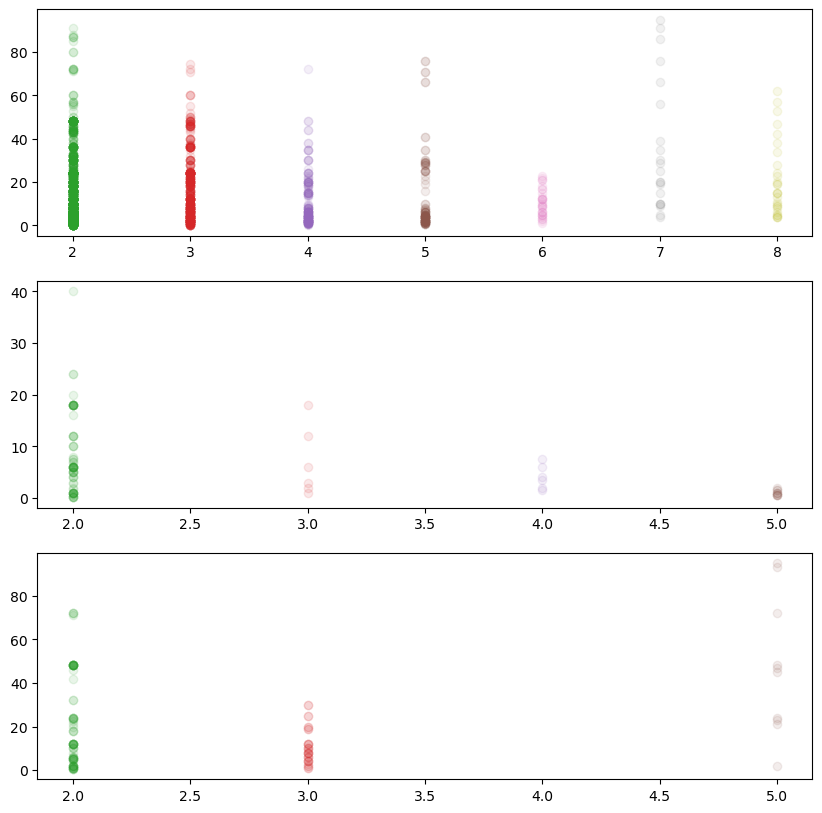

In [66]:
f, axs = plt.subplots(3,1,figsize=(10,10))
for ax, (k, v) in zip(axs, time_op_div.items()):
    for i, _v in enumerate(v):
        ax.scatter([i]*len(_v), _v, alpha=0.1)

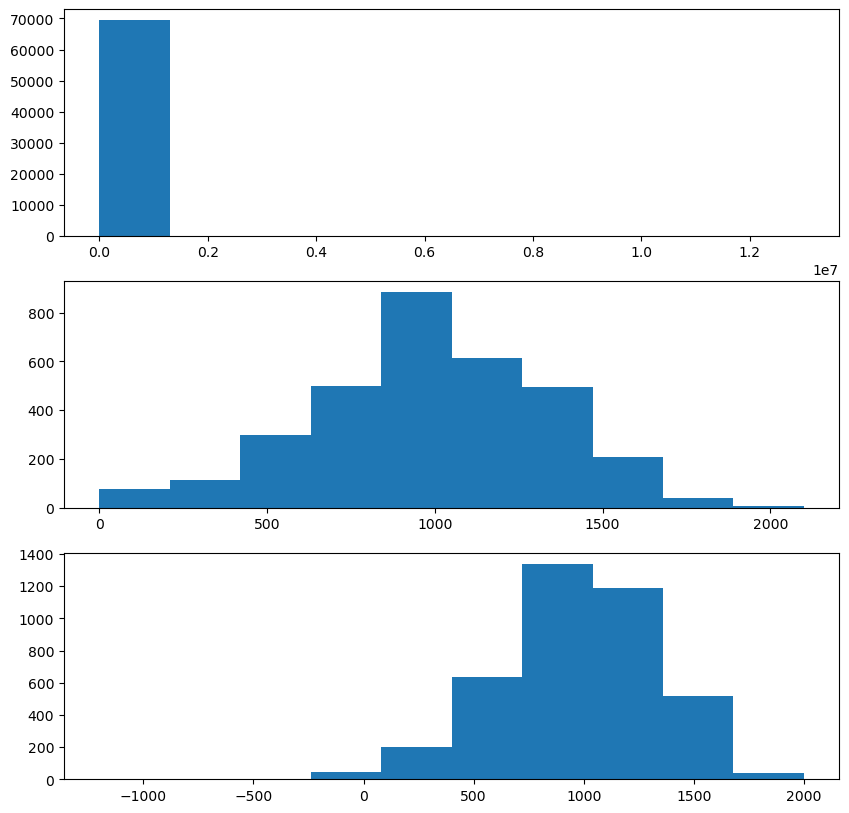

In [726]:
f, axs = plt.subplots(3,1,figsize=(10, 10))
for i, (k, v) in enumerate(temp_op_div.items()):
    axs[i].hist(np.hstack([np.hstack(_v) for _v in v if len(_v) > 0]))

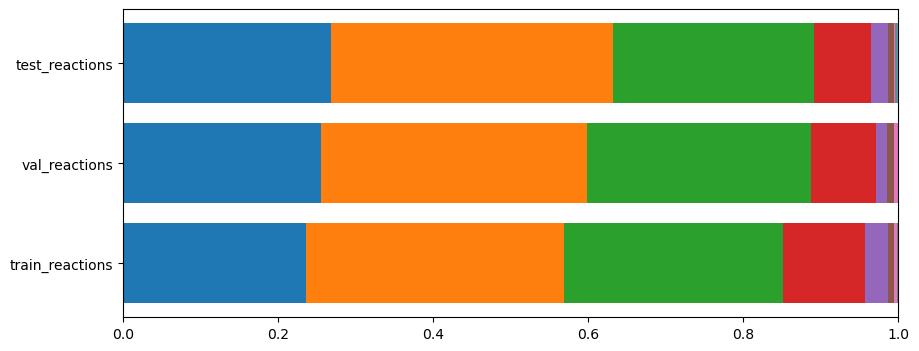

In [682]:
import matplotlib as mpl
f, ax = plt.subplots(1,1,figsize=(10,4))
for i, (k, v) in enumerate(has_temp_op.items()):
    b = 0.
    for j, _v in enumerate(v):
        ax.barh(y=i, width=_v/np.sum(v), left=b, color=mpl.cm.tab10(j))
        b += _v/np.sum(v)
ax.set_yticks([0,1,2], labels=list(has_temp_op.keys()))